In [1]:
import pickle
from pathlib import Path

import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

SAM_MODEL_DIR = Path("../sa_models")

In [8]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

In [2]:
img_path = Path("/tf/notebooks/gotmeals/data/sample_data/IMG_0119.PNG")
if img_path.exists():
    img = Image.open(img_path)
    img = np.asarray(img)
    print(f"Image shape: {img.shape}")
else:
    print(f"File not found {img_path}")

Image shape: (3024, 4032, 3)


In [3]:
sam_checkpoint = SAM_MODEL_DIR.joinpath("sam_vit_h_4b8939.pth")
if not sam_checkpoint.exists():
    print(f"File not found {sam_checkpoint}")
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
sam_model = sam_model_registry[model_type](sam_checkpoint)
sam_model.to(device=device)
predictor = SamPredictor(sam_model)

Using device: cuda


In [5]:
predictor.set_image(img)

In [6]:
with open("points.pkl", "rb") as f:
    points = pickle.load(f)

In [73]:
input_point = np.asarray([points[0]])
input_label = np.asarray([1])  # 1 foreground point 2 background point
print(input_point, input_label)

[[1044.7632875  2573.41504207]] [1]


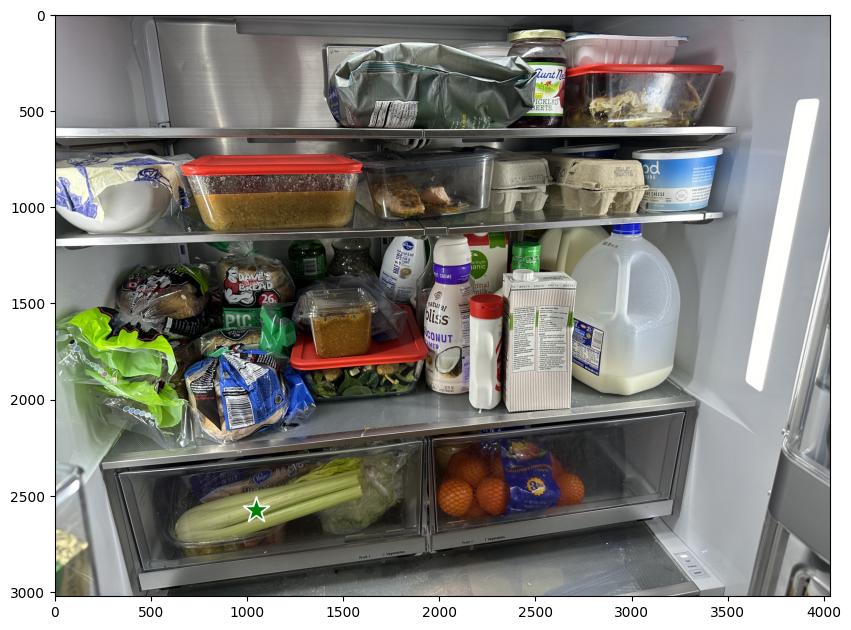

In [74]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis("on")
plt.show()

In [75]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
max_score_index = np.argmax(scores)

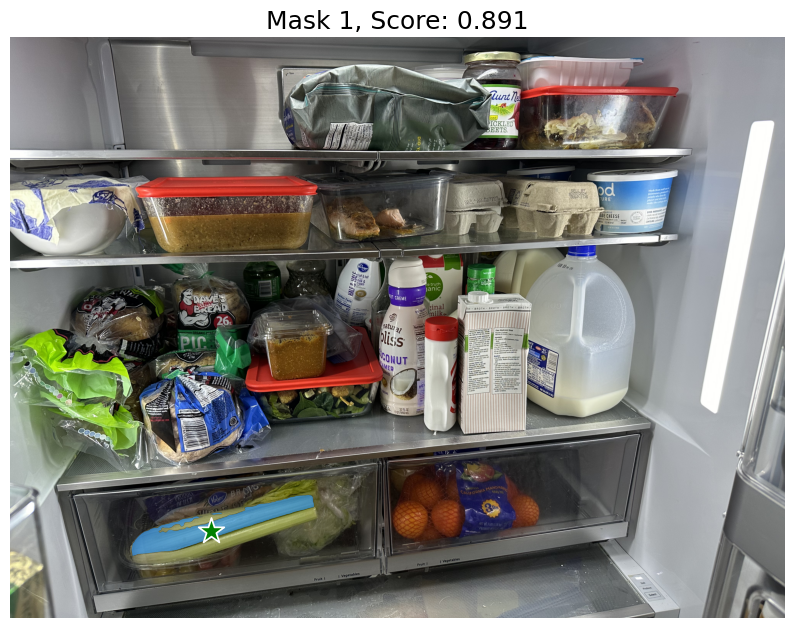

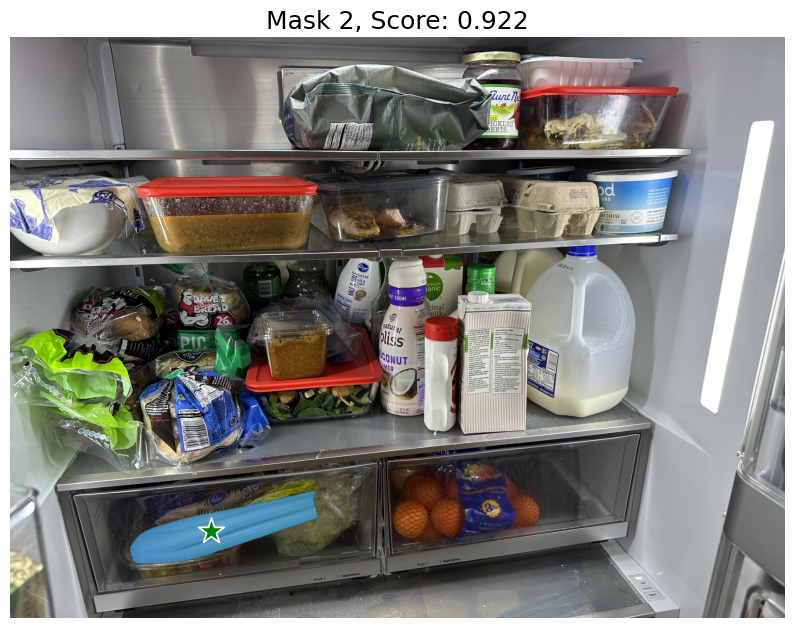

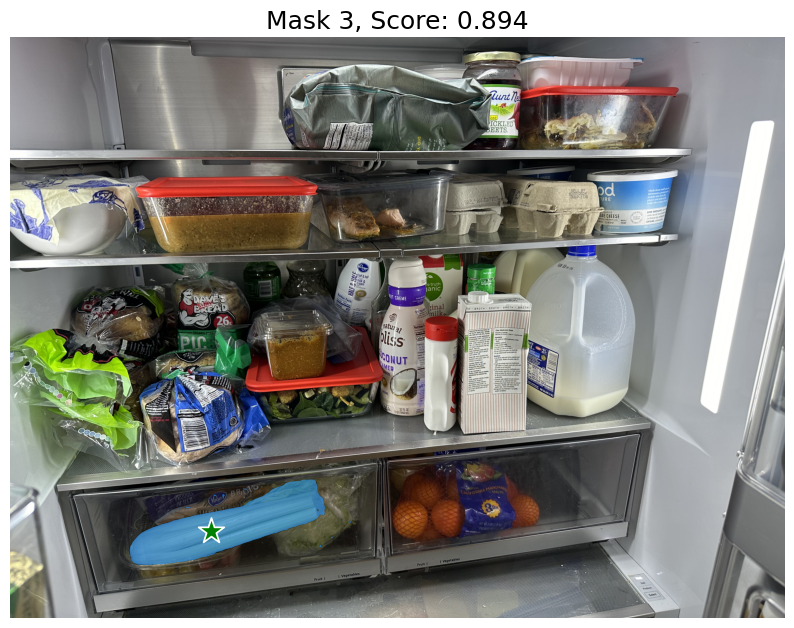

In [76]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()

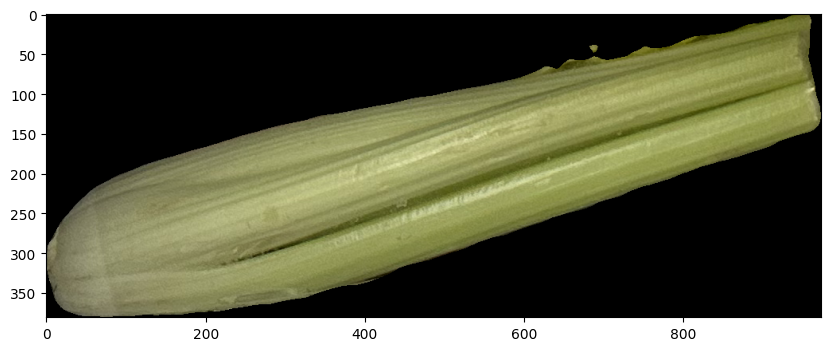

In [77]:
best_mask = masks[max_score_index, :, :]
final_image = img * best_mask[..., np.newaxis]
nonzero_indices = np.nonzero(final_image.sum(axis=-1))
min_y, min_x = np.min(nonzero_indices, axis=1)
max_y, max_x = np.max(nonzero_indices, axis=1)
cropped_image = final_image[min_y : max_y + 1, min_x : max_x + 1, :]
plt.figure(figsize=(10, 10))
plt.imshow(cropped_image)
plt.axis("on")
plt.show()